In [1]:
# for recall clean df (after EDA)
%store -r billboard_df_eda 

## IDEA:
#### Cluster analisys in order to create some **'fictitious users'**

#### so we want to add a column 'users' that will be the users that evaluate the songs (trought the variable valence) 

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#! pip install plotly_express
import plotly.subplots as sp
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd

## But before we want to obtain a smaller df, that contain only the 'maingenre' with the **highst number of songs**

In [3]:
billboard_df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 0 to 29502
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          27901 non-null  int64  
 1   SongID                         27901 non-null  object 
 2   Performer                      27901 non-null  object 
 3   Song                           27901 non-null  object 
 4   spotify_genre                  27901 non-null  object 
 5   spotify_track_duration_minute  27901 non-null  float64
 6   spotify_track_explicit         27901 non-null  object 
 7   spotify_track_album            27901 non-null  object 
 8   danceability                   27901 non-null  float64
 9   energy                         27901 non-null  float64
 10  key                            27901 non-null  float64
 11  loudness                       27901 non-null  float64
 12  mode                           27901 non-null  floa

In [4]:
#we take the 17 maingenre
numbers_of_genere=billboard_df_eda.maingenere.value_counts()[0:17]
numbers_of_genere
#this is the less present maingenere
worst_genere=billboard_df_eda.maingenere.value_counts()[17:]
worst_genere
#we make a copy of the initial dataframe
top17_genere_df=billboard_df_eda.copy()
top17_genere_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 0 to 29502
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          27901 non-null  int64  
 1   SongID                         27901 non-null  object 
 2   Performer                      27901 non-null  object 
 3   Song                           27901 non-null  object 
 4   spotify_genre                  27901 non-null  object 
 5   spotify_track_duration_minute  27901 non-null  float64
 6   spotify_track_explicit         27901 non-null  object 
 7   spotify_track_album            27901 non-null  object 
 8   danceability                   27901 non-null  float64
 9   energy                         27901 non-null  float64
 10  key                            27901 non-null  float64
 11  loudness                       27901 non-null  float64
 12  mode                           27901 non-null  floa

In [5]:
#we drop all the genres after the 17th
for i in worst_genere.index:
    top17_genere_df=top17_genere_df.drop(top17_genere_df[top17_genere_df.maingenere==i].index)

In [6]:
# we can see that the dimension of the df is smaller (not much), with respect to the billboard_df_eda, since we considered only the 17 maingenre
top17_genere_df.shape

(27319, 22)

In [7]:
billboard_df_eda.shape

(27901, 22)

### We are interested in finding which rows of the dataframe are similar, to put them in different groups: we want **homogeneity within the group** and **heterogeneity between groups**

In [8]:
# first we have to define our variables of interest
column_to_use=['danceability','energy','key','loudness','mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence','time_signature','tempo','spotify_track_duration_minute']
#and define another dataframe with only this variable
cluster_df=top17_genere_df[column_to_use]
cluster_df.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,time_signature,tempo,spotify_track_duration_minute
0,0.590,0.570,5.37,-9.970,0.75,0.0700,0.400,0.080000,0.200,0.63,3.89,117.760,3.43
1,0.590,0.570,5.37,-9.970,0.75,0.0700,0.400,0.080000,0.200,0.63,3.89,117.760,3.43
2,0.154,0.185,5.00,-14.063,1.00,0.0315,0.911,0.000267,0.112,0.15,4.00,83.969,2.77


In [9]:
top17_genere_df.maingenere.unique()

array(['other', 'pop', 'rock', 'rap', 'indie', 'country', 'soul', 'funk',
       'blues', 'dance', 'disco', 'jazz', 'metal', 'folk', 'r&b', 'house',
       'latin'], dtype=object)

In [10]:
#now we have to standardize the columns of this dataframe, the main reason to do this is to garant that all the varaible have the same scale
#but there are other
cluster_df=(cluster_df-cluster_df.mean()/cluster_df.std())

 ### Cluster Analysis is based  on **distances within observation**, so we have to compute it

In [11]:
# we define an empty list where we store the sum squered of the distance for each number of cluster
ssd=[]
# Fit the KMeans model to the data with a range of different numbers of clusters - assign a center and verify how many cluster minimize the distance
for k in range(1,13):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(cluster_df)
    ssd.append(kmeans.inertia_)

### ***How to choose how many cluster*** ?
### we have to build a scree plot and look for the 'Elbow point'

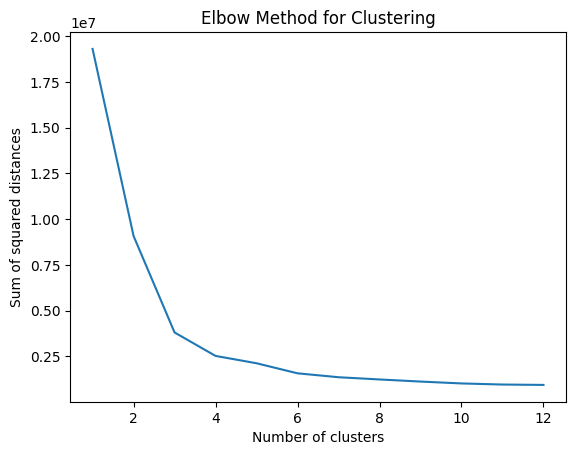

In [12]:
# Elbow point: is the point where the the ssd start to linear increase
plt.plot(range(1,13),ssd)
plt.title('Elbow Method for Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

#### **we can see that our 'Elbow point' is at k=4, so we try to build a model using 4 cluster**

In [13]:
# Starting to build a model
# I decide to select 4 cluster (seeing the elbow point), moreover using 5 or 6 but gives bad results
kmeans=KMeans(n_clusters=4,random_state=1)
kmeans.fit(cluster_df)

KMeans(n_clusters=4, random_state=1)

In [14]:
#To generate the clusters with the KMeans algorithm, we can use the predict() method on the fitted KMeans model
clusters=kmeans.predict(cluster_df)
#print(clusters[:10])

### How to evalute if the model that we have built is a good model ?

**Silhouette method: is an index that move from -1 to 1**, provides a measure of how similar an object is to the cluster it belongs to compared to other clusters

In [15]:
silhouette_score(cluster_df,clusters)

np.float64(0.42350955616274394)

## To visualize the Clusters

In [16]:
#to visualize the cluster we need to reduce the data to two dimension, we have to use PCA (principal component analysis)
# the aim is to lost less information as possible, reduction the dimansion of the data
pca=PCA(n_components=2)
df_2d=pca.fit_transform(cluster_df)

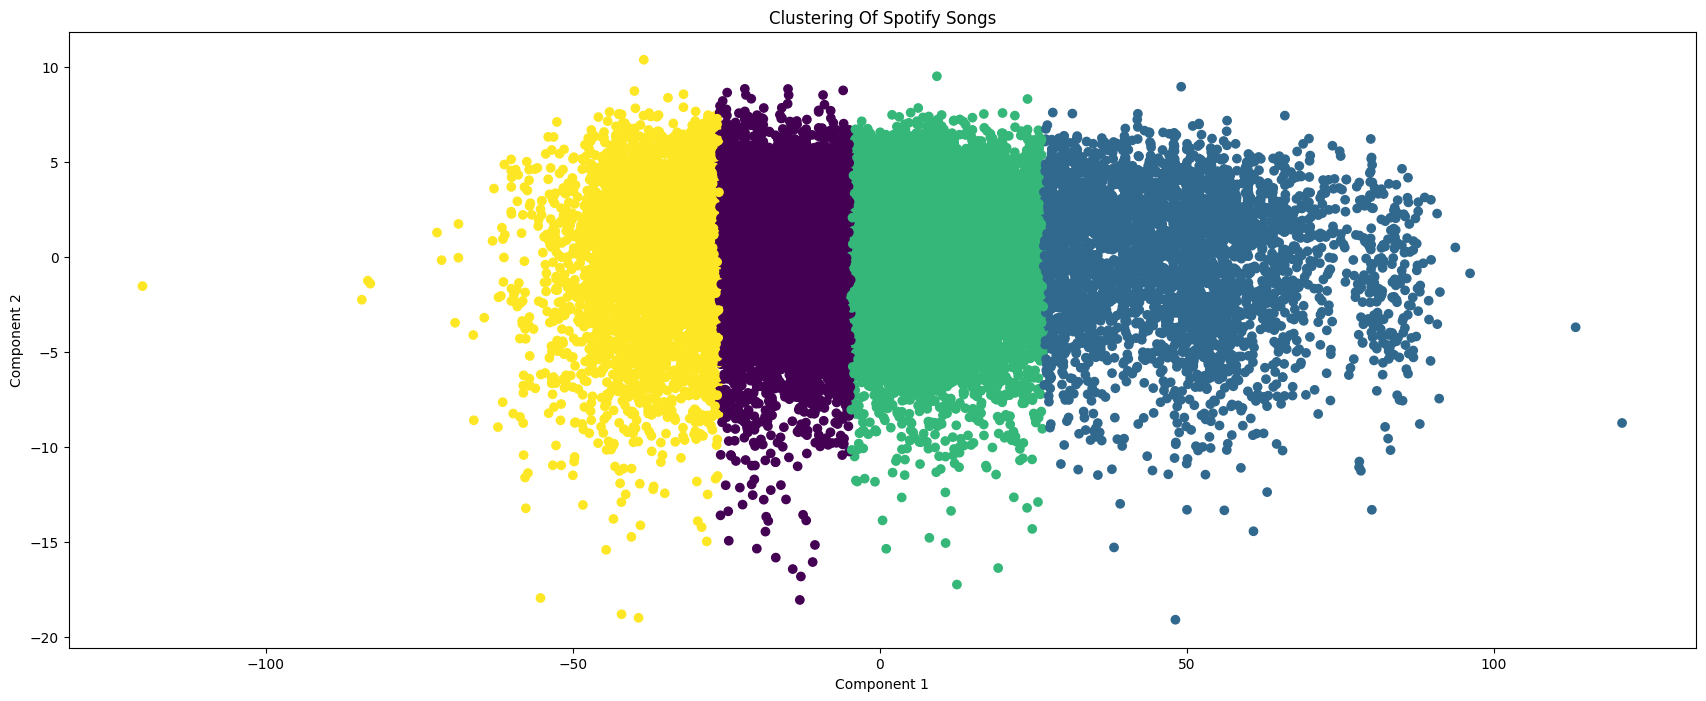

In [17]:
plt.figure(figsize=(21,8))
plt.scatter(df_2d[:, 0], df_2d[:, 1], c=clusters)
plt.title('Clustering Of Spotify Songs')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### We can notice that we have **4 clear groups**

#### We build a subplot where we want to look for the single cluster

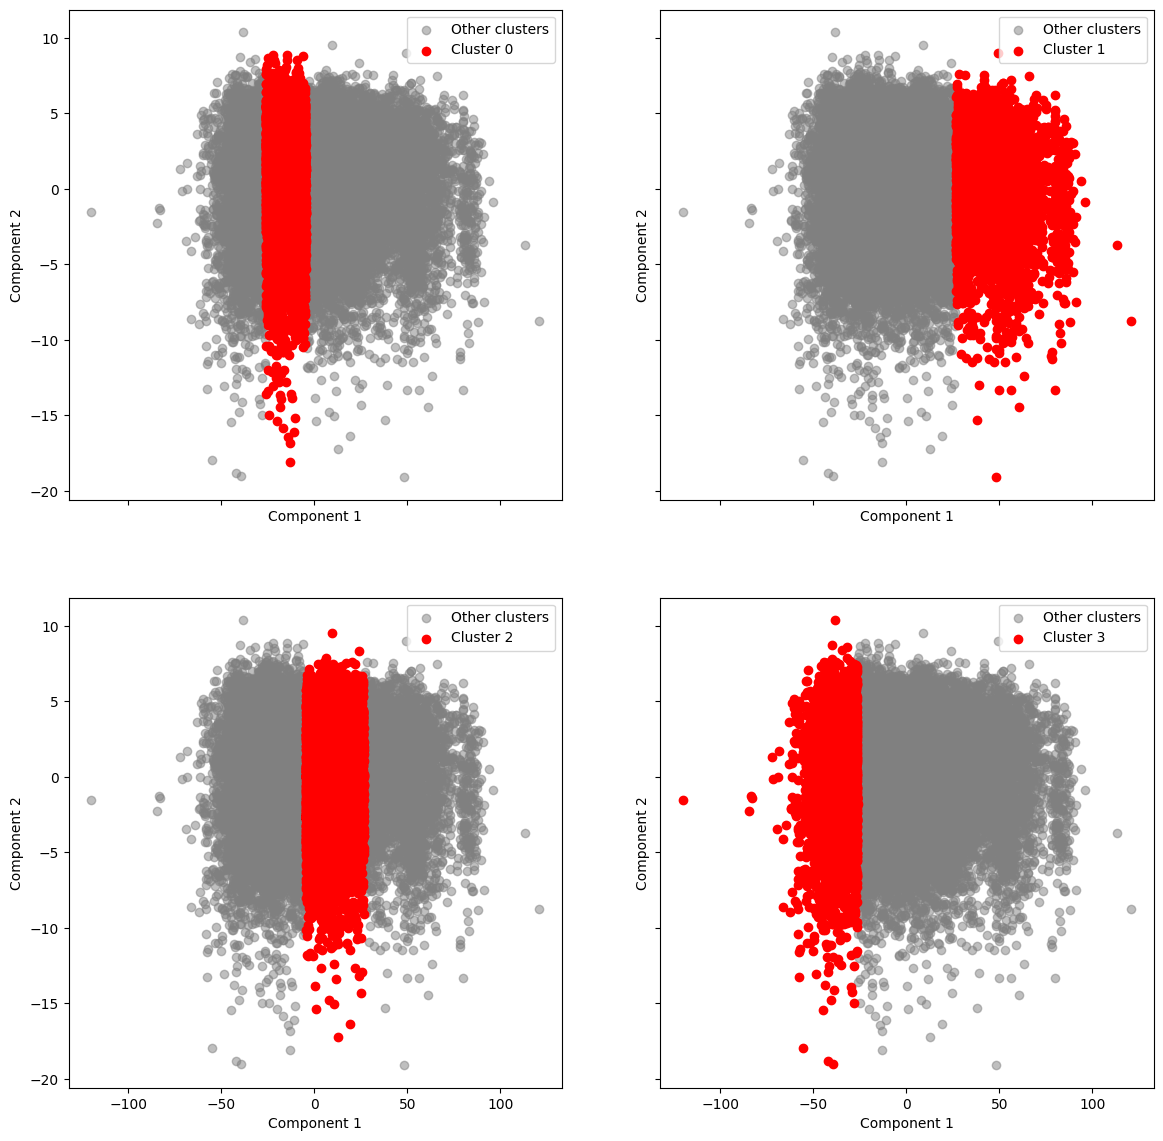

In [18]:
# Get the unique cluster assignments
unique_clusters = np.unique(clusters)

# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14), sharex=True, sharey=True)

# Flatten the array of subplots to make it easier to iterate over
axs = axs.flatten()

# Iterate over the clusters
for i, cluster in enumerate(unique_clusters):
    # Select the data points belonging to the current cluster
    df_cluster = df_2d[clusters == cluster]

    # Select the data points belonging to other clusters
    df_other_clusters = df_2d[clusters != cluster]

    # Plot the data points belonging to other clusters in gray
    axs[i].scatter(df_other_clusters[:, 0], df_other_clusters[:, 1], c='gray', label='Other clusters', alpha=0.5)

    # Plot the data points belonging to the current cluster with a different color
    axs[i].scatter(df_cluster[:, 0], df_cluster[:, 1], c='red', label='Cluster {}'.format(cluster))

    # Set the x and y labels for the current subplot
    axs[i].set_xlabel('Component 1')
    axs[i].set_ylabel('Component 2')

    # Add a legend to the current subplot
    axs[i].legend()

plt.show()

### Now we look for the characteristics of the **single cluster**

In [19]:
four_cluster_df=cluster_df.copy()
four_cluster_df['cluster']=clusters

In [20]:
# now we can explore the characteristics of the individual cluster
cluster_mean=four_cluster_df.groupby('cluster').mean()
print(cluster_mean)

         danceability    energy       key  loudness      mode  speechiness  \
cluster                                                                      
0           -3.545223 -2.693601  3.725876 -6.291301 -1.052849    -0.872705   
1           -3.681439 -2.655384  3.547085 -5.444438 -1.006683    -0.843655   
2           -3.572081 -2.674871  3.654935 -6.148418 -1.030830    -0.874516   
3           -3.636123 -2.767973  3.667434 -6.596958 -1.012822    -0.858928   

         acousticness  instrumentalness  liveness   valence  time_signature  \
cluster                                                                       
0           -0.847027         -0.238015 -1.115931 -2.093258       -9.158671   
1           -0.858355         -0.242328 -1.103167 -2.116933       -9.194109   
2           -0.850864         -0.231576 -1.106281 -2.089352       -9.135491   
3           -0.749084         -0.245499 -1.107344 -2.189711       -9.175197   

              tempo  spotify_track_duration_minute  
clu

In [21]:
#we drop tempo in the main graph since is out of scale with respect to the other variable 
cluster_mean_wo_tempo=cluster_mean.drop('tempo', axis=1)
#cluster_mean_only_tempo=cluster_mean['tempo']

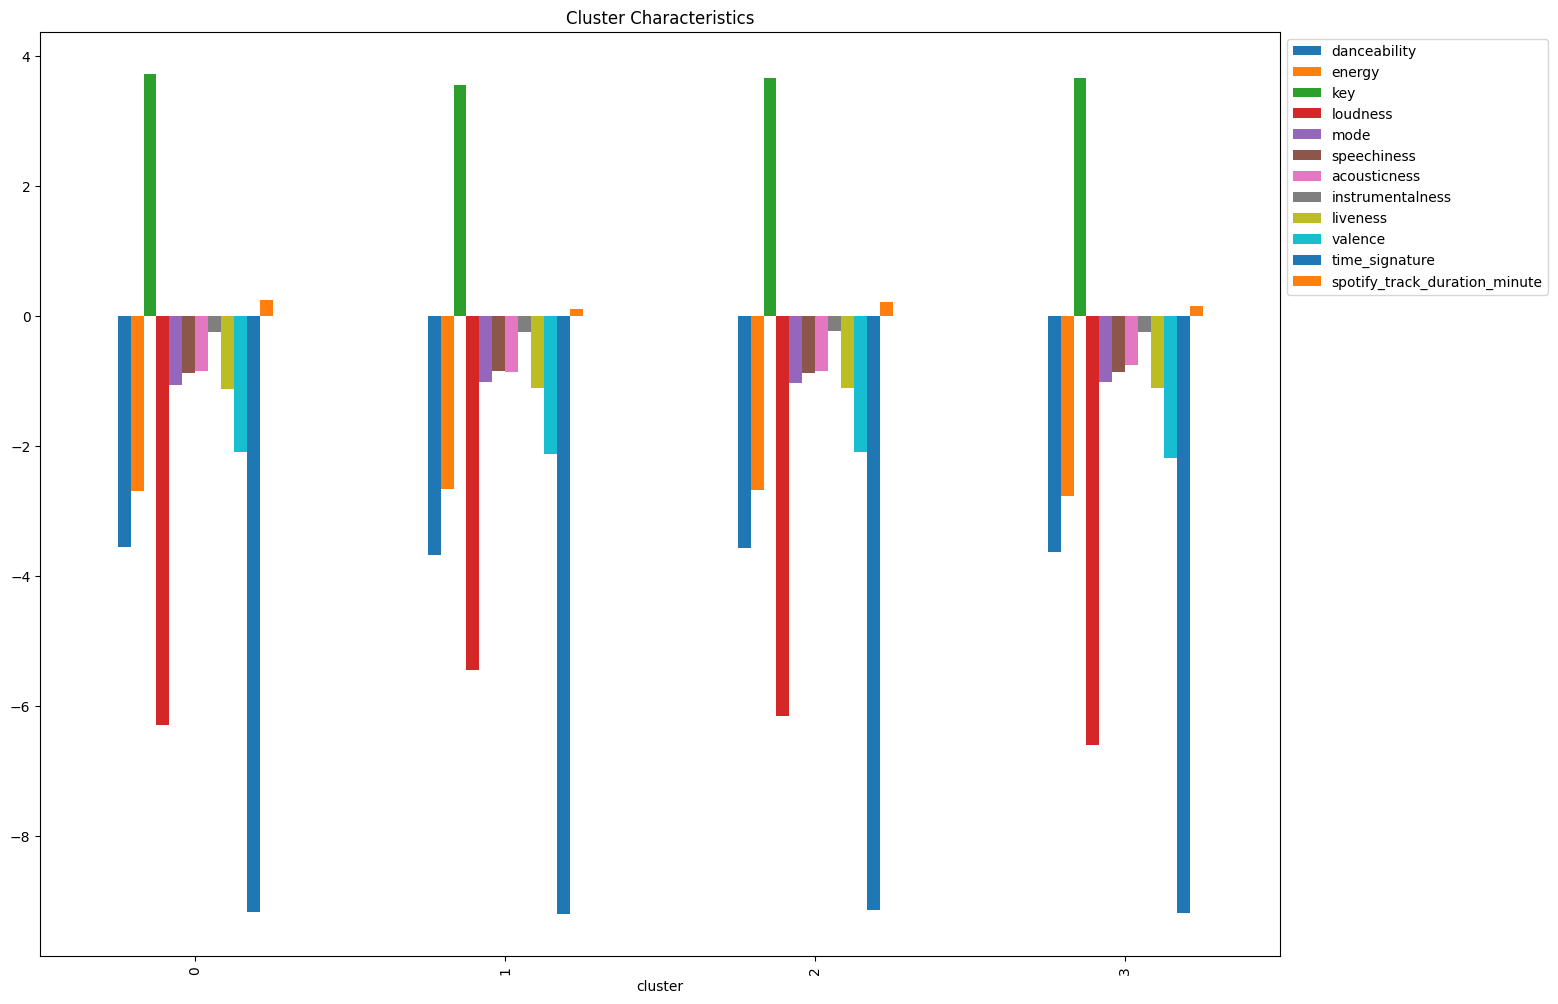

In [22]:
#we build a plot
cluster_mean_wo_tempo.plot(kind='bar',figsize=(16,12))
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

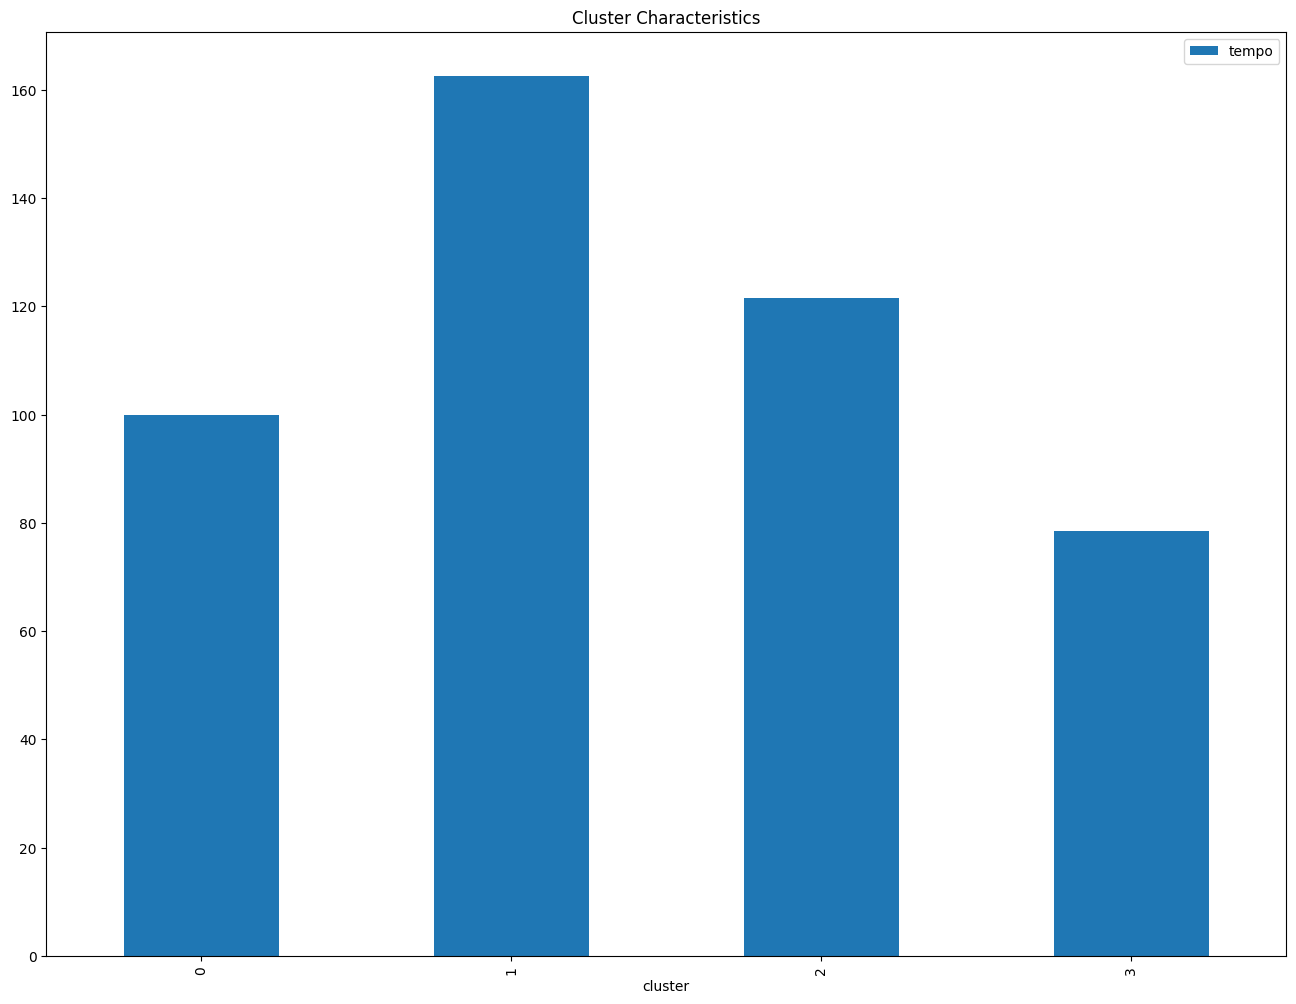

In [23]:
# now we plot tempo 
cluster_mean['tempo'].plot(kind='bar',figsize=(16,12))
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## This could be usefull for our pourpose

### we find the frequences of the songs that belongs to each cluster

In [24]:
etichette=kmeans.labels_
etichette

array([2, 2, 3, ..., 2, 3, 0], dtype=int32)

In [25]:
cluster1=top17_genere_df[etichette==0]
c1_n_songs_maingenere=cluster1.maingenere.value_counts()
cluster2=top17_genere_df[etichette==1]
c2_n_songs_maingenere=cluster2.maingenere.value_counts()
cluster3=top17_genere_df[etichette==2]
c3_n_songs_maingenere=cluster3.maingenere.value_counts()
cluster4=top17_genere_df[etichette==3]
c4_n_songs_maingenere=cluster4.maingenere.value_counts()

In [26]:
# we create a df with the info that we obtained (songs for cluster, divided by genre)
c1234_df=pd.concat([c1_n_songs_maingenere,c2_n_songs_maingenere,c3_n_songs_maingenere,c4_n_songs_maingenere],axis=1)
c1234_df.columns=['c1','c2','c3','c4']
c1234_df

,c1,c2,c3,c4
maingenere,,,,
pop,1859,1051,3365,1315
rock,1216,778,2541,621
other,794,329,2528,516
soul,690,299,1066,444
rap,496,484,796,483
country,479,486,838,415
disco,216,32,308,46
dance,108,32,179,28
jazz,108,42,178,76


In [27]:
### we want to visualize it
fig1 = px.bar(c1234_df, x=c1234_df.index, y=['c1','c2','c3','c4'], barmode='group',text_auto=True)

fig1.update_layout(title=dict(text="Distribution of genre for each cluster", font=dict(size=50), automargin=True, yref='paper'))

fig1.show()

In [28]:
plt.figure(figsize=(12,8))
fig0 = px.pie(c1234_df, values="c1", names=c1234_df.index,hole=0.5,width =800,height=700)
fig0.update_layout(title_text="Distribution of genre for cluster 1")
fig0.update_traces(textinfo='value+label+percent')
fig0.show()

<Figure size 1200x800 with 0 Axes>

In [29]:
plt.figure(figsize=(12,8))
fig0 = px.pie(c1234_df, values="c2", names=c1234_df.index,hole=0.5,width =800,height=700)
fig0.update_layout(title_text="Distribution of genre for cluster 2")
fig0.update_traces(textinfo='value+label+percent')
fig0.show()

<Figure size 1200x800 with 0 Axes>

In [30]:
plt.figure(figsize=(12,8))
fig0 = px.pie(c1234_df, values="c3", names=c1234_df.index,hole=0.5,width =800,height=700)
fig0.update_layout(title_text="Distribution of genre for cluster 3")
fig0.update_traces(textinfo='value+label+percent')
fig0.show()

<Figure size 1200x800 with 0 Axes>

In [31]:
plt.figure(figsize=(12,8))
fig0 = px.pie(c1234_df, values="c4", names=c1234_df.index,hole=0.5,width =800,height=700)
fig0.update_layout(title_text="Distribution of genre for cluster 4")
fig0.update_traces(textinfo='value+label+percent')
fig0.show()

<Figure size 1200x800 with 0 Axes>

---

## NEW CLUSTER WITH NAME SONG IN THE INDEX AND WITHOUT valence

 We try to build again the CLUSTER, buy we DON'T CONSIDER the variable VALENCE as a numeric variable for the aggregation 
and we put **as index the names of the songs** in order to understand in wich claster the songs is, and from this 
since we choose that each cluster is related to one user, which song the user listen and wich is the rate associated 

In [32]:
billboard_df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 0 to 29502
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          27901 non-null  int64  
 1   SongID                         27901 non-null  object 
 2   Performer                      27901 non-null  object 
 3   Song                           27901 non-null  object 
 4   spotify_genre                  27901 non-null  object 
 5   spotify_track_duration_minute  27901 non-null  float64
 6   spotify_track_explicit         27901 non-null  object 
 7   spotify_track_album            27901 non-null  object 
 8   danceability                   27901 non-null  float64
 9   energy                         27901 non-null  float64
 10  key                            27901 non-null  float64
 11  loudness                       27901 non-null  float64
 12  mode                           27901 non-null  floa

In [33]:
#richiamo top 17 generi df
top17_genere_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27319 entries, 0 to 29502
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          27319 non-null  int64  
 1   SongID                         27319 non-null  object 
 2   Performer                      27319 non-null  object 
 3   Song                           27319 non-null  object 
 4   spotify_genre                  27319 non-null  object 
 5   spotify_track_duration_minute  27319 non-null  float64
 6   spotify_track_explicit         27319 non-null  object 
 7   spotify_track_album            27319 non-null  object 
 8   danceability                   27319 non-null  float64
 9   energy                         27319 non-null  float64
 10  key                            27319 non-null  float64
 11  loudness                       27319 non-null  float64
 12  mode                           27319 non-null  floa

### Put the song id in the index

In [34]:
top17_genere_name_index_df = top17_genere_df.copy()

In [35]:
top17_genere_name_index_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27319 entries, 0 to 29502
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          27319 non-null  int64  
 1   SongID                         27319 non-null  object 
 2   Performer                      27319 non-null  object 
 3   Song                           27319 non-null  object 
 4   spotify_genre                  27319 non-null  object 
 5   spotify_track_duration_minute  27319 non-null  float64
 6   spotify_track_explicit         27319 non-null  object 
 7   spotify_track_album            27319 non-null  object 
 8   danceability                   27319 non-null  float64
 9   energy                         27319 non-null  float64
 10  key                            27319 non-null  float64
 11  loudness                       27319 non-null  float64
 12  mode                           27319 non-null  floa

In [36]:
top17_genere_name_index_df.drop(columns=['index'], inplace=True)

In [37]:
#check if the SongID is unique
len(top17_genere_name_index_df.SongID.unique())
#ATTENZIONE alcune canzoni hanno lo stesso nome
#ELIMINARE LE CANZONI CON STESSO SONGID!!!!! (FARE)

27207

In [38]:
top17_genere_name_index_df.index = top17_genere_name_index_df.SongID
top17_genere_name_index_df.drop(columns='SongID')

,Performer,Song,spotify_genre,spotify_track_duration_minute,spotify_track_explicit,spotify_track_album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,maingenere
SongID,,,,,,,,,,,,,,,,,,,,
-twistin'-White Silver SandsBill Black's Combo,Bill Black's Combo,-twistin'-White Silver Sands,[],3.43,unknown,single,0.590,0.570,5.37,-9.970,0.75,0.0700,0.40000,0.080000,0.2000,0.630,117.760,3.89,22.16,other
¿Dònde Està Santa Claus? (Where Is Santa Claus?)Augie Rios,Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus?),['novelty'],3.43,unknown,single,0.590,0.570,5.37,-9.970,0.75,0.0700,0.40000,0.080000,0.2000,0.630,117.760,3.89,22.16,other
......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",2.77,False,The Essential Andy Williams,0.154,0.185,5.00,-14.063,1.00,0.0315,0.91100,0.000267,0.1120,0.150,83.969,4.00,38.00,pop
...And Then There Were DrumsSandy Nelson,Sandy Nelson,...And Then There Were Drums,"['rock-and-roll', 'space age pop', 'surf music']",2.87,False,Compelling Percussion,0.588,0.672,11.00,-17.278,0.00,0.0361,0.00256,0.745000,0.1450,0.801,121.962,4.00,11.00,rock
...Baby One More TimeBritney Spears,Britney Spears,...Baby One More Time,"['dance pop', 'pop', 'post-teen pop']",3.52,False,...Baby One More Time (Digital Deluxe Version),0.759,0.699,0.00,-5.745,0.00,0.0307,0.20200,0.000131,0.4430,0.907,92.960,4.00,77.00,pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZombieBad Wolves,Bad Wolves,Zombie,"['alternative metal', 'metal', 'post-grunge']",4.25,False,Zombie,0.448,0.826,2.00,-3.244,0.00,0.0319,0.00756,0.000000,0.1170,0.190,77.093,4.00,74.00,metal
ZoomFuture,Future,Zoom,"['atl hip hop', 'hip hop', 'pop rap', 'rap', '...",4.64,True,FUTURE,0.852,0.438,9.00,-7.673,1.00,0.4260,0.01450,0.000000,0.2630,0.627,150.945,4.00,51.00,rap
ZoomLil' Boosie Featuring Yung Joc,Lil' Boosie Featuring Yung Joc,Zoom,"['baton rouge rap', 'deep southern trap']",3.79,unknown,single,0.730,0.650,5.30,-6.750,0.57,0.2100,0.15000,0.010000,0.2000,0.500,121.310,4.00,60.30,rap


In [39]:
top17_genere_name_index_df

,SongID,Performer,Song,spotify_genre,spotify_track_duration_minute,spotify_track_explicit,spotify_track_album,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,maingenere
SongID,,,,,,,,,,,,,,,,,,,,,
-twistin'-White Silver SandsBill Black's Combo,-twistin'-White Silver SandsBill Black's Combo,Bill Black's Combo,-twistin'-White Silver Sands,[],3.43,unknown,single,0.590,0.570,5.37,...,0.75,0.0700,0.40000,0.080000,0.2000,0.630,117.760,3.89,22.16,other
¿Dònde Està Santa Claus? (Where Is Santa Claus?)Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus?),['novelty'],3.43,unknown,single,0.590,0.570,5.37,...,0.75,0.0700,0.40000,0.080000,0.2000,0.630,117.760,3.89,22.16,other
......And Roses And RosesAndy Williams,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",2.77,False,The Essential Andy Williams,0.154,0.185,5.00,...,1.00,0.0315,0.91100,0.000267,0.1120,0.150,83.969,4.00,38.00,pop
...And Then There Were DrumsSandy Nelson,...And Then There Were DrumsSandy Nelson,Sandy Nelson,...And Then There Were Drums,"['rock-and-roll', 'space age pop', 'surf music']",2.87,False,Compelling Percussion,0.588,0.672,11.00,...,0.00,0.0361,0.00256,0.745000,0.1450,0.801,121.962,4.00,11.00,rock
...Baby One More TimeBritney Spears,...Baby One More TimeBritney Spears,Britney Spears,...Baby One More Time,"['dance pop', 'pop', 'post-teen pop']",3.52,False,...Baby One More Time (Digital Deluxe Version),0.759,0.699,0.00,...,0.00,0.0307,0.20200,0.000131,0.4430,0.907,92.960,4.00,77.00,pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZombieBad Wolves,ZombieBad Wolves,Bad Wolves,Zombie,"['alternative metal', 'metal', 'post-grunge']",4.25,False,Zombie,0.448,0.826,2.00,...,0.00,0.0319,0.00756,0.000000,0.1170,0.190,77.093,4.00,74.00,metal
ZoomFuture,ZoomFuture,Future,Zoom,"['atl hip hop', 'hip hop', 'pop rap', 'rap', '...",4.64,True,FUTURE,0.852,0.438,9.00,...,1.00,0.4260,0.01450,0.000000,0.2630,0.627,150.945,4.00,51.00,rap
ZoomLil' Boosie Featuring Yung Joc,ZoomLil' Boosie Featuring Yung Joc,Lil' Boosie Featuring Yung Joc,Zoom,"['baton rouge rap', 'deep southern trap']",3.79,unknown,single,0.730,0.650,5.30,...,0.57,0.2100,0.15000,0.010000,0.2000,0.500,121.310,4.00,60.30,rap


### We are interested in finding which rows of the dataframe are similar, to put them in different groups: we want **homogeneity within the group** and **heterogeneity between groups**

In [40]:
# first we have to define our variables of interest
column_to_use_no_valence=['danceability','energy','key','loudness','mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','time_signature','tempo','spotify_track_duration_minute']
#and define another dataframe with only this variable
cluster_index_df=top17_genere_name_index_df[column_to_use]
cluster_index_df.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,time_signature,tempo,spotify_track_duration_minute
SongID,,,,,,,,,,,,,
-twistin'-White Silver SandsBill Black's Combo,0.590,0.570,5.37,-9.970,0.75,0.0700,0.400,0.080000,0.200,0.63,3.89,117.760,3.43
¿Dònde Està Santa Claus? (Where Is Santa Claus?)Augie Rios,0.590,0.570,5.37,-9.970,0.75,0.0700,0.400,0.080000,0.200,0.63,3.89,117.760,3.43
......And Roses And RosesAndy Williams,0.154,0.185,5.00,-14.063,1.00,0.0315,0.911,0.000267,0.112,0.15,4.00,83.969,2.77


In [41]:
top17_genere_name_index_df.maingenere.unique()

array(['other', 'pop', 'rock', 'rap', 'indie', 'country', 'soul', 'funk',
       'blues', 'dance', 'disco', 'jazz', 'metal', 'folk', 'r&b', 'house',
       'latin'], dtype=object)

In [42]:
#now we have to standardize the columns of this dataframe, the main reason to do this is to garant that all the varaible have the same scale
#but there are other
cluster_index_df=(cluster_index_df-cluster_index_df.mean()/cluster_df.std())

 ### Cluster Analysis is based  on **distances within observation**, so we have to compute it

In [43]:
# we define an empty list where we store the sum squered of the distance for each number of cluster
ssd_index=[]
# Fit the KMeans model to the data with a range of different numbers of clusters - assign a center and verify how many cluster minimize the distance
for k in range(1,13):
    kmeans_index=KMeans(n_clusters=k)
    kmeans_index.fit(cluster_index_df)
    ssd_index.append(kmeans_index.inertia_)

### ***How to choose how many cluster*** ?
### we have to build a scree plot and look for the 'Elbow point'

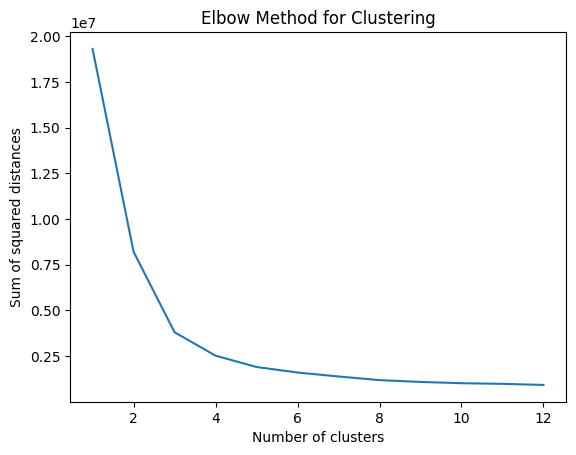

In [44]:
# Elbow point: is the point where the the ssd start to linear increase
plt.plot(range(1,13),ssd_index)
plt.title('Elbow Method for Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

## from the elbow method we see that the number of clusters seems to be 3 or 5

 We decide to build our model using 5 cluster since we have the best results in term of shiluette index

In [45]:
# Starting to build a model
# I decide to select 5 cluster (seeing the elbow point)
kmeans_index=KMeans(n_clusters=5,random_state=1)
kmeans_index.fit(cluster_index_df)

KMeans(n_clusters=5, random_state=1)

In [46]:
#To generate the clusters with the KMeans algorithm, we can use the predict() method on the fitted KMeans model
clusters_index=kmeans_index.predict(cluster_index_df)
#print(clusters[:10])

### How to evalute if the model that we have built is a good model ?

**Silhouette method: is an index that move from -1 to 1**, provides a measure of how similar an object is to the cluster it belongs to compared to other clusters

In [47]:
silhouette_score(cluster_index_df,clusters_index)

np.float64(0.4553278549460407)

## To visualize the Clusters

ATTENZIONE DA QUA IN POI NON HO MODIFICATO I NOMI AD ECCEZIONE DEI CLUSTER (CREATI IN PRECEDENZA (index))

In [48]:
#to visualize the cluster we need to reduce the data to two dimension, we have to use PCA (principal component analysis)
# the aim is to lost less information as possible, reduction the dimansion of the data
pca=PCA(n_components=2)
df_2d=pca.fit_transform(cluster_index_df)

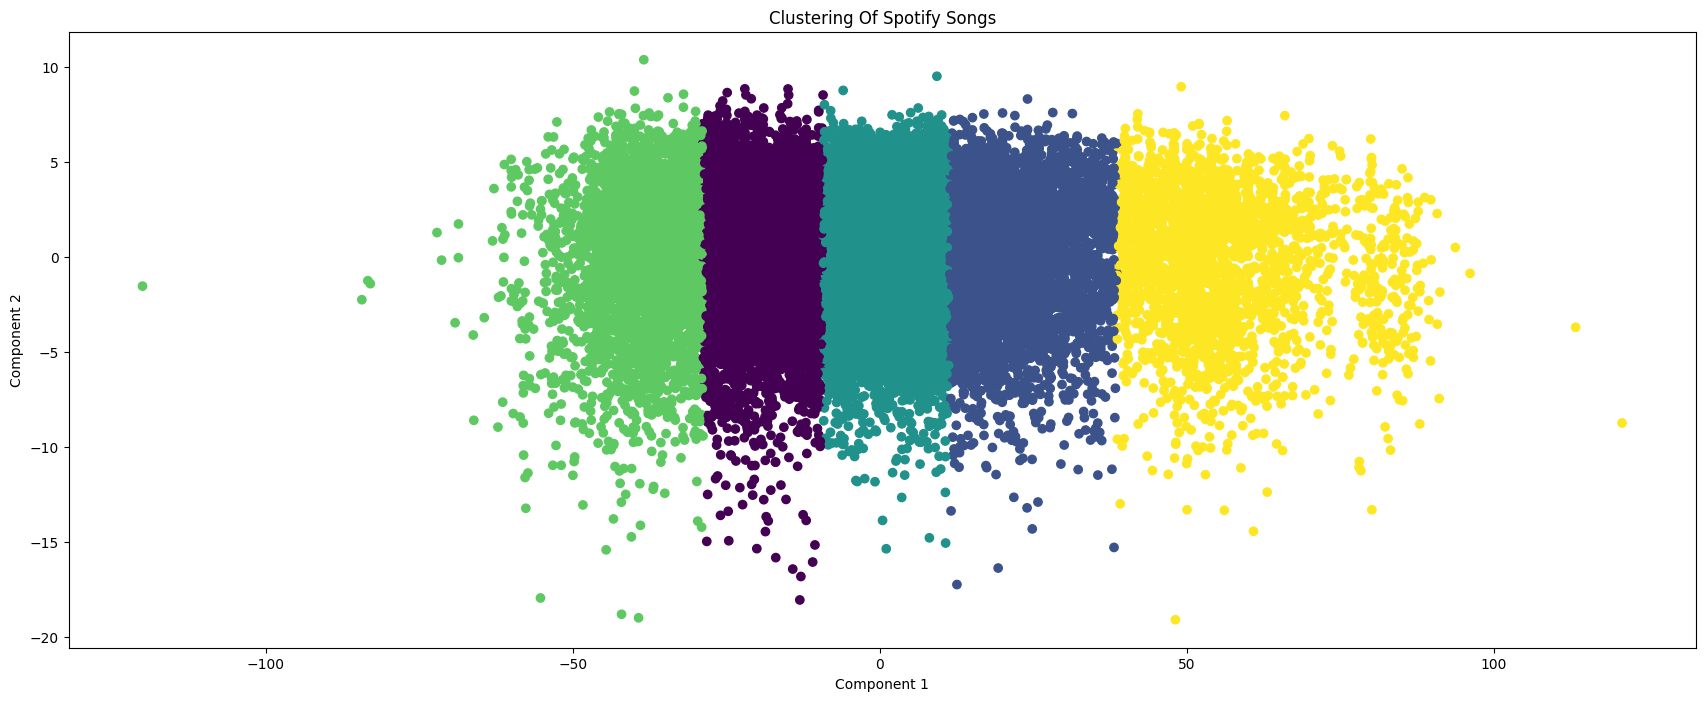

In [49]:
plt.figure(figsize=(21,8))
plt.scatter(df_2d[:, 0], df_2d[:, 1], c=clusters_index)
plt.title('Clustering Of Spotify Songs')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### We can notice that we have **5 clear groups**

#### We build a subplot where we want to look for the single cluster

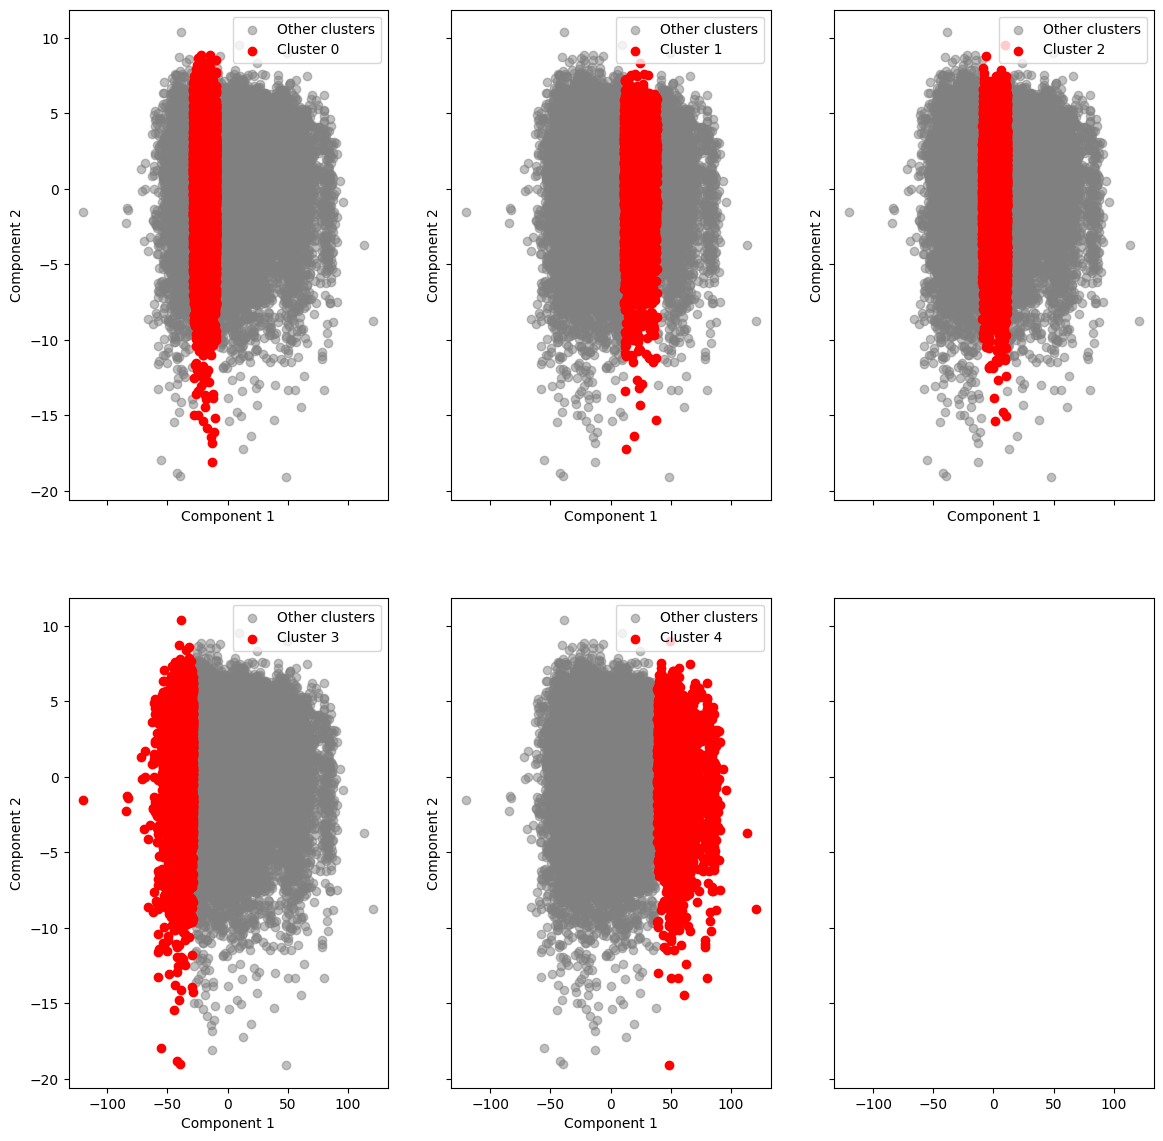

In [50]:
# Get the unique cluster assignments
unique_clusters_index = np.unique(clusters_index)

# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,14), sharex=True, sharey=True)

# Flatten the array of subplots to make it easier to iterate over
axs = axs.flatten()

# Iterate over the clusters
for i, cluster in enumerate(unique_clusters_index):
    # Select the data points belonging to the current cluster
    df_cluster = df_2d[clusters_index == cluster]

    # Select the data points belonging to other clusters
    df_other_clusters = df_2d[clusters_index != cluster]

    # Plot the data points belonging to other clusters in gray
    axs[i].scatter(df_other_clusters[:, 0], df_other_clusters[:, 1], c='gray', label='Other clusters', alpha=0.5)

    # Plot the data points belonging to the current cluster with a different color
    axs[i].scatter(df_cluster[:, 0], df_cluster[:, 1], c='red', label='Cluster {}'.format(cluster))

    # Set the x and y labels for the current subplot
    axs[i].set_xlabel('Component 1')
    axs[i].set_ylabel('Component 2')

    # Add a legend to the current subplot
    axs[i].legend()

plt.show()

### Now we look for the characteristics of the **single cluster**

In [51]:
cluster_index_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,time_signature,tempo,spotify_track_duration_minute
SongID,,,,,,,,,,,,,
-twistin'-White Silver SandsBill Black's Combo,-3.600005,-2.736155,3.788196,-7.383982,-1.009363,-0.869805,-0.736734,-0.190511,-1.101011,-2.084042,-9.193521,113.164923,-0.038559
¿Dònde Està Santa Claus? (Where Is Santa Claus?)Augie Rios,-3.600005,-2.736155,3.788196,-7.383982,-1.009363,-0.869805,-0.736734,-0.190511,-1.101011,-2.084042,-9.193521,113.164923,-0.038559
......And Roses And RosesAndy Williams,-4.036005,-3.121155,3.418196,-11.476982,-0.759363,-0.908305,-0.225734,-0.270244,-1.189011,-2.564042,-9.083521,79.373923,-0.698559
...And Then There Were DrumsSandy Nelson,-3.602005,-2.634155,9.418196,-14.691982,-1.759363,-0.903705,-1.134174,0.474489,-1.156011,-1.913042,-9.083521,117.366923,-0.598559
...Baby One More TimeBritney Spears,-3.431005,-2.607155,-1.581804,-3.158982,-1.759363,-0.909105,-0.934734,-0.270380,-0.858011,-1.807042,-9.083521,88.364923,0.051441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZombieBad Wolves,-3.742005,-2.480155,0.418196,-0.657982,-1.759363,-0.907905,-1.129174,-0.270511,-1.184011,-2.524042,-9.083521,72.497923,0.781441
ZoomFuture,-3.338005,-2.868155,7.418196,-5.086982,-0.759363,-0.513805,-1.122234,-0.270511,-1.038011,-2.087042,-9.083521,146.349923,1.171441
ZoomLil' Boosie Featuring Yung Joc,-3.460005,-2.656155,3.718196,-4.163982,-1.189363,-0.729805,-0.986734,-0.260511,-1.101011,-2.214042,-9.083521,116.714923,0.321441


In [52]:
four_cluster_index_df=cluster_index_df.copy() #FORSE QUA DEVO INSERIRE GLI ID??
four_cluster_index_df['cluster']=clusters_index

In [53]:
four_cluster_index_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,time_signature,tempo,spotify_track_duration_minute,cluster
SongID,,,,,,,,,,,,,,
-twistin'-White Silver SandsBill Black's Combo,-3.600005,-2.736155,3.788196,-7.383982,-1.009363,-0.869805,-0.736734,-0.190511,-1.101011,-2.084042,-9.193521,113.164923,-0.038559,2
¿Dònde Està Santa Claus? (Where Is Santa Claus?)Augie Rios,-3.600005,-2.736155,3.788196,-7.383982,-1.009363,-0.869805,-0.736734,-0.190511,-1.101011,-2.084042,-9.193521,113.164923,-0.038559,2
......And Roses And RosesAndy Williams,-4.036005,-3.121155,3.418196,-11.476982,-0.759363,-0.908305,-0.225734,-0.270244,-1.189011,-2.564042,-9.083521,79.373923,-0.698559,3
...And Then There Were DrumsSandy Nelson,-3.602005,-2.634155,9.418196,-14.691982,-1.759363,-0.903705,-1.134174,0.474489,-1.156011,-1.913042,-9.083521,117.366923,-0.598559,2
...Baby One More TimeBritney Spears,-3.431005,-2.607155,-1.581804,-3.158982,-1.759363,-0.909105,-0.934734,-0.270380,-0.858011,-1.807042,-9.083521,88.364923,0.051441,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZombieBad Wolves,-3.742005,-2.480155,0.418196,-0.657982,-1.759363,-0.907905,-1.129174,-0.270511,-1.184011,-2.524042,-9.083521,72.497923,0.781441,3
ZoomFuture,-3.338005,-2.868155,7.418196,-5.086982,-0.759363,-0.513805,-1.122234,-0.270511,-1.038011,-2.087042,-9.083521,146.349923,1.171441,1
ZoomLil' Boosie Featuring Yung Joc,-3.460005,-2.656155,3.718196,-4.163982,-1.189363,-0.729805,-0.986734,-0.260511,-1.101011,-2.214042,-9.083521,116.714923,0.321441,2


# Try merge

In [54]:
#we add the column user
User = four_cluster_index_df['cluster']
display(User)

SongID
-twistin'-White Silver SandsBill Black's Combo                2
¿Dònde Està Santa Claus? (Where Is Santa Claus?)Augie Rios    2
......And Roses And RosesAndy Williams                        3
...And Then There Were DrumsSandy Nelson                      2
...Baby One More TimeBritney Spears                           0
                                                             ..
ZombieBad Wolves                                              3
ZoomFuture                                                    1
ZoomLil' Boosie Featuring Yung Joc                            2
Zorba The GreekHerb Alpert & The Tijuana Brass                3
Zunga ZengK7                                                  0
Name: cluster, Length: 27319, dtype: int32

In [55]:
# we merge the df, using as index the variable SongID
# we also add the column user
merge_df = pd.merge(top17_genere_name_index_df, User, left_index=True, right_index=True, how='inner')
display(merge_df.head(3))

,SongID,Performer,Song,spotify_genre,spotify_track_duration_minute,spotify_track_explicit,spotify_track_album,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,maingenere,cluster
SongID,,,,,,,,,,,,,,,,,,,,,
-twistin'-White Silver SandsBill Black's Combo,-twistin'-White Silver SandsBill Black's Combo,Bill Black's Combo,-twistin'-White Silver Sands,[],3.43,unknown,single,0.590,0.570,5.37,...,0.0700,0.400,0.080000,0.200,0.63,117.760,3.89,22.16,other,2
¿Dònde Està Santa Claus? (Where Is Santa Claus?)Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus?),['novelty'],3.43,unknown,single,0.590,0.570,5.37,...,0.0700,0.400,0.080000,0.200,0.63,117.760,3.89,22.16,other,2
......And Roses And RosesAndy Williams,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",2.77,False,The Essential Andy Williams,0.154,0.185,5.00,...,0.0315,0.911,0.000267,0.112,0.15,83.969,4.00,38.00,pop,3


In [56]:
# i want to verify if in the index we have repetition 
merge_df.index.duplicated()


array([False, False, False, ..., False, False, False])

In [57]:
merge_unique_df=merge_df[~merge_df.index.duplicated(keep='first')]
merge_unique_df.head(3)

,SongID,Performer,Song,spotify_genre,spotify_track_duration_minute,spotify_track_explicit,spotify_track_album,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,maingenere,cluster
SongID,,,,,,,,,,,,,,,,,,,,,
-twistin'-White Silver SandsBill Black's Combo,-twistin'-White Silver SandsBill Black's Combo,Bill Black's Combo,-twistin'-White Silver Sands,[],3.43,unknown,single,0.590,0.570,5.37,...,0.0700,0.400,0.080000,0.200,0.63,117.760,3.89,22.16,other,2
¿Dònde Està Santa Claus? (Where Is Santa Claus?)Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus?),['novelty'],3.43,unknown,single,0.590,0.570,5.37,...,0.0700,0.400,0.080000,0.200,0.63,117.760,3.89,22.16,other,2
......And Roses And RosesAndy Williams,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",2.77,False,The Essential Andy Williams,0.154,0.185,5.00,...,0.0315,0.911,0.000267,0.112,0.15,83.969,4.00,38.00,pop,3


In [58]:
#we check if we have duplicated
merge_unique_df.duplicated().sum()

np.int64(0)

In [59]:
# now since we have the index that is SongID and also the column SongID
# we drop the column SongID
merge_unique_df.drop(columns=['SongID'],inplace=True)
merge_unique_df.head(2)

C:\Users\lovoa\AppData\Local\Temp\ipykernel_27104\2815161336.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Performer,Song,spotify_genre,spotify_track_duration_minute,spotify_track_explicit,spotify_track_album,danceability,energy,key,loudness,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,maingenere,cluster
SongID,,,,,,,,,,,,,,,,,,,,,
-twistin'-White Silver SandsBill Black's Combo,Bill Black's Combo,-twistin'-White Silver Sands,[],3.43,unknown,single,0.59,0.57,5.37,-9.97,...,0.07,0.4,0.08,0.2,0.63,117.76,3.89,22.16,other,2
¿Dònde Està Santa Claus? (Where Is Santa Claus?)Augie Rios,Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus?),['novelty'],3.43,unknown,single,0.59,0.57,5.37,-9.97,...,0.07,0.4,0.08,0.2,0.63,117.76,3.89,22.16,other,2


In [60]:
%store merge_unique_df

Stored 'merge_unique_df' (DataFrame)
